In [1]:
import pandas as pd

X_train_path = "public/X_train.csv"
X_test_path = "public/X_test.csv"
y_train_path = "public/y_train.csv"

X = pd.read_csv(X_train_path, index_col="id")
X_out = pd.read_csv(X_test_path, index_col="id")
y = pd.read_csv(y_train_path, index_col="id")

X.shape, y.shape, X_out.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-100, 100))

# Scale each row individually for X_train
X = X.apply(lambda row: pd.Series(scaler.fit_transform(row.values.reshape(-1, 1)).ravel()), axis=1)

# Scale each row individually for X_test
X_out = X_out.apply(lambda row: pd.Series(scaler.fit_transform(row.values.reshape(-1, 1)).ravel()), axis=1)

X.shape, X_out.shape



((5117, 17807), (3411, 17807))

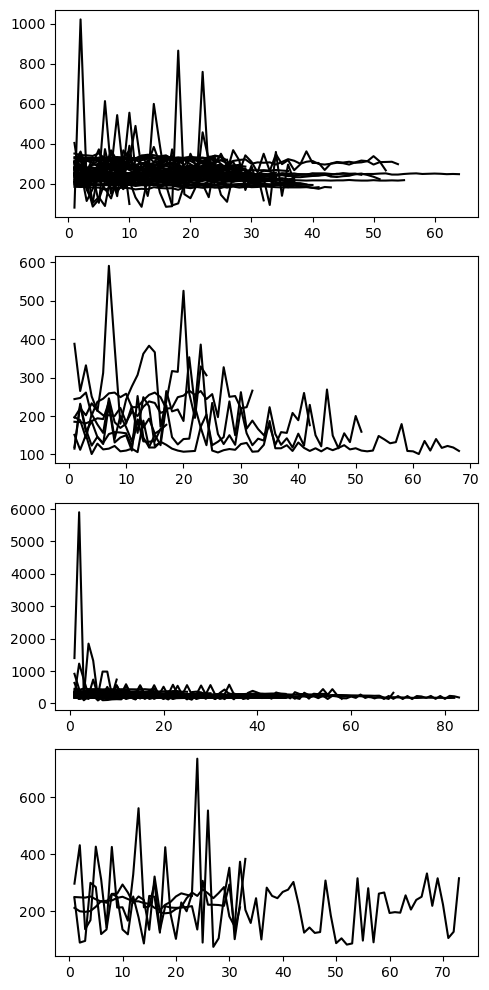

In [ ]:
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt

# Extract the R peaks from the first row of X_train

fig, axs = plt.subplots(4, 1, figsize=(5, 10))
for i in range(100):
    row = X.loc[i].dropna().to_numpy(dtype='float32')
    rpeaks, = ecg.engzee_segmenter(signal=row, sampling_rate=300)
    beat = ecg.extract_heartbeats(signal=row, rpeaks=rpeaks, sampling_rate=300)
    peak_distances = pd.Series(beat['rpeaks']).diff().dropna()

    axs[y.loc[i, 'y']].plot(peak_distances, color='black')
    # Iterate over the classes and plot the peak distances

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


In [13]:
import biosppy.signals.ecg as ecg
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.stats import entropy
import pywt


# Define a function to extract time domain features
def extract_ecg_features(data, i):
    # Compute the heart rate
    row = data.loc[i].dropna().to_numpy(dtype='float32')
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal=row, sampling_rate=300, show=False)

    # Return the extracted features
    return ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate


def extract_time_features(data):
    # Compute the mean RR interval
    mean_rr = np.mean(np.diff(data))

    # Compute the standard deviation of RR intervals
    std_rr = np.std(np.diff(data))

    # Compute the root mean square of successive RR interval differences
    rms_rr = np.sqrt(np.mean(np.square(np.diff(data))))

    # Compute the skewness of RR intervals
    skew_rr = skew(np.diff(data))

    # Compute the kurtosis of RR intervals
    kurt_rr = kurtosis(np.diff(data))

    # Return the extracted features
    return mean_rr, std_rr, rms_rr, skew_rr, kurt_rr

def extract_frequency_features(data, fs=300):
    # Compute the FFT of the signal
    if(data.shape[0] == 0):
        return None, None
    fft_values = fft(data)
    fft_values = 2.0*np.abs(fft_values[:fs//2])/len(data)

    # Compute the power spectral density of the signal
    freqs, psd_values = welch(data, fs=fs)

    # Compute the peak frequency
    # peak_freq = freqs[np.argmax(psd_values)]

    # Compute the median frequency
    median_freq = freqs[len(freqs)//2]

    # Compute the spectral entropy
    spectral_entropy = entropy(psd_values)

    # Return the extracted features
    return median_freq, spectral_entropy

import numpy as np

def calculate_poincare_descriptors(rr_intervals):
    # Calculate the differences between successive RR intervals
    rr_diff = np.diff(rr_intervals)

    # Calculate SD1 and SD2
    sd1 = np.sqrt(np.std(rr_diff, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rr_intervals, ddof=1) ** 2 - 0.5 * np.std(rr_diff, ddof=1) ** 2)

    return sd1, sd2


def extract_wavelet_features(signal, wavelet='db4', level=3):
    if(signal.shape[0] == 0):
        return [None, None, None, None], [None, None, None, None]

    # Compute the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Compute the standard deviation of each set of coefficients
    stds = [np.std(coeff) for coeff in coeffs]

    # Compute the mean of each set of coefficients
    means = [np.mean(coeff) for coeff in coeffs]

    # Return the extracted features
    return stds, means

def extract_morphological_features(data):
    if (data.shape[0] == 0):
        return [None for _ in range(12)]

    # Compute the R-peak amplitude
    r_amplitude = np.max(data)

    # Compute the Q and S wave amplitudes
    max_ind = np.argmax(data)
    q_amplitude = np.min(data[:np.argmax(data)], initial=0)
    s_amplitude = np.min(data[np.argmax(data):], initial=0)

    # Compute the T wave amplitude
    t_amplitude = None
    if np.argmax(data) < data.shape[0]:
        t_amplitude = np.max(data[np.argmax(data):], initial=0)

    # Compute the P wave amplitude
    p_amplitude = None
    if np.argmin(data) > 0:
        p_amplitude = np.max(data[:np.argmin(data)], initial=0)

    # Compute the QRS complex duration
    qrs_duration = None
    if np.argmax(data) > 0:
        qrs_duration = np.argmax(data) - np.argmin(data[:np.argmax(data)])

    # Compute the QT interval
    qt_interval = None
    if np.argmax(data) < data.shape[0] and np.argmax(data) > 0:
        qt_interval = np.argmax(data[np.argmax(data):]) - np.argmin(data[:np.argmax(data)])

    # Compute the PR interval
    pr_interval = None
    if(np.argmin(data) > 0):
        pr_interval = np.argmax(data) - np.argmax(data[:np.argmin(data)])

    # Compute the ST segment
    st_segment = None
    if np.argmax(data) < data.shape[0] and np.argmax(data) > 0:
        st_segment = np.argmax(data[np.argmax(data):]) - np.argmax(data)

    # Compute the RR interval
    rr_interval = None
    if len(np.where(data == np.max(data))[0]) > 1:
        rr_interval = np.where(data == np.max(data))[0][1] - np.where(data == np.max(data))[0][0]

    # Compute the P wave duration
    p_duration = None
    if np.argmin(data) > 0:
        p_duration = np.argmax(data) - np.argmax(data[:np.argmin(data)])

    # Compute the T wave duration
    t_duration = None
    if np.argmax(data) < data.shape[0] and np.argmax(data) > 0:
        t_duration = np.argmax(data[np.argmax(data):]) - np.argmax(data)

    # Return the extracted features
    return r_amplitude, q_amplitude, s_amplitude, t_amplitude, p_amplitude, qrs_duration, qt_interval, pr_interval, st_segment, rr_interval, p_duration, t_duration


# Extract time domain features from the first row of X_train
ecg_features = ['ts', 'filtered', 'rpeaks', 'templates_ts', 'mean_templates', 'heart_rate_ts', 'heart_rate']
time_features = ['mean', 'std', 'rms', 'skew', 'kurt']
frequency_features = ['median_freq', 'spectral_entropy']
poincarre_features = ['sd1', 'sd2']
wavelet_features = ['wave_std', 'wave_mean']

def extract_features(X_data, N):

    features = pd.DataFrame(columns=ecg_features)

    for i in range(N):
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = extract_ecg_features(X_data, i)
        mean_templates = np.mean(templates, axis=0)
        features.loc[len(features)] = [ts, filtered, rpeaks, templates_ts, mean_templates, heart_rate_ts, heart_rate]

    for ec in ecg_features:
        tf = features[ec].map(extract_time_features)
        for i, t in enumerate(time_features):
            features[ec + "_" + t] = tf.map(lambda x: x[i])
        ff = features[ec].map(extract_frequency_features)
        for i, f in enumerate(frequency_features):
            features[ec + "_" + f] = ff.map(lambda x: x[i])
        pf = features[ec].map(calculate_poincare_descriptors)
        for i, p in enumerate(poincarre_features):
            features[ec + "_" + p] = tf.map(lambda x: x[i])
        wf = features[ec].map(extract_wavelet_features)
        for i, w in enumerate(wavelet_features):
            wave = wf.map(lambda x: x[i])
            for j in range(4):
                features[ec + "_" + w + "_" + str(j)] = wave.map(lambda x: x[j])

    morphological_features = ['r_amplitude', 'q_amplitude', 's_amplitude', 't_amplitude', 'p_amplitude', 'qrs_duration', 'qt_interval', 'pr_interval']
    # print(features['templates'])
    mf = features['mean_templates'].map(extract_morphological_features)
    for i, m in enumerate(morphological_features):
        features['templates_' + m] = mf.map(lambda x: x[i])

    return features.drop(ecg_features, axis=1)



In [14]:
train_features = extract_features(X, X.shape[0])
out_features = extract_features(X_out, X_out.shape[0])

print(train_features.shape, out_features.shape)

/Users/mchami/anaconda3/envs/amltask2/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 66, using nperseg = 66
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/mchami/anaconda3/envs/amltask2/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 35, using nperseg = 35
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/mchami/anaconda3/envs/amltask2/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/mchami/anaconda3/envs/amltask2/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/mcham

(5117, 127) (3411, 127)


/var/folders/l2/j581hbb53nb9hn1507fwv24w0000gn/T/ipykernel_1451/3273622910.py:162: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[ec + "_" + w + "_" + str(j)] = wave.map(lambda x: x[j])
/var/folders/l2/j581hbb53nb9hn1507fwv24w0000gn/T/ipykernel_1451/3273622910.py:162: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[ec + "_" + w + "_" + str(j)] = wave.map(lambda x: x[j])
/var/folders/l2/j581hbb53nb9hn1507fwv24w0000gn/T/ipykernel_1451/3273622910.py:162: PerformanceWarning: DataFrame is highly fragmented.  This is us

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer


def train_model(X_data, y_data, model):
    X_model = X_data.to_numpy()
    y_model = y_data.to_numpy().ravel()

    imputer = SimpleImputer(strategy='median')
    X_model = imputer.fit_transform(X_model)

    X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='micro')

    print("F1 Score:", f1)
    return f1

def predict_model(X_data, model):
    X_model = X_data.to_numpy()

    imputer = SimpleImputer(strategy='median')
    X_model = imputer.fit_transform(X_model)

    y_pred = model.predict(X_model)

    return y_pred


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define the models
models = [
    ('Logistic Regression', LogisticRegression(multi_class='multinomial', random_state=42)),
    ('SVM', SVC(kernel='linear', C=1.0, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Train and evaluate each model
for name, model in models:
    print(f"Training {name}...")
    f1 = train_model(X, y, model)
    print(f"{name} F1 Score: {f1}\n")

Training Logistic Regression...


/Users/mchami/anaconda3/envs/amltask2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.482421875
Logistic Regression F1 Score: 0.482421875

Training SVM...
F1 Score: 0.44921875
SVM F1 Score: 0.44921875

Training Decision Tree...
F1 Score: 0.4814453125
Decision Tree F1 Score: 0.4814453125

Training Random Forest...
F1 Score: 0.580078125
Random Forest F1 Score: 0.580078125

Training K-Nearest Neighbors...
F1 Score: 0.5654296875
K-Nearest Neighbors F1 Score: 0.5654296875

Training Naive Bayes...
F1 Score: 0.08203125
Naive Bayes F1 Score: 0.08203125

Training Neural Network...
F1 Score: 0.5751953125
Neural Network F1 Score: 0.5751953125

Training Gradient Boosting...
F1 Score: 0.5703125
Gradient Boosting F1 Score: 0.5703125



In [16]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
f1 = train_model(X, y, svm)
print(f1)

F1 Score: 0.44921875
0.44921875


In [ ]:
out = pd.DataFrame(index=X_out.index, columns=['y'])
y_out = predict_model(out_features, svm)
out['y'] = y_out
out.to_csv("out.csv")